In [314]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [315]:
# инициализируем переменные
chunksize = 10**7
notebook_path = os.path.abspath("homework4.ipynb")
notebook_dir = os.path.join(os.path.dirname(notebook_path))
data_path = f'{notebook_dir}/data/'
train_path = f'{data_path}train.csv'
lectures_path = f'{data_path}lectures.csv'
questions_path = f'{data_path}questions.csv'
performance_dynamics_df = pd.DataFrame()
last_qstn_row = None
users_stat = None
questions_stat = None
qtags_stat = None
qparts_stat = None
lectures_stat = None

In [316]:
def harvest_data(tr_qstn, tr_lect):
    '''
    Функция сбора и агрегирования данных из переодически подгружаемых из источника данных датафреймов
    :param tr_qstn: датафрейм содержащий информацию о ответах пользователелями на вопросы
    :param tr_lect: датафрейм содержащий информацию о просмтотрах пользователями лекций
    '''
    # декларация глобальных переменных которые используются в работе функции
    global max_ts
    global users_stat
    global questions_stat
    global qtags_stat
    global qparts_stat
    global lectures_stat

    # проводим группировку по полям user_id, answered_correctly, progress_stage
    if tr_qstn is not None:
        # создаем колонку для каждого теста содержащую какой процент от максимального времени прохождения всех тестов
        # сответсвует времени текущего теста
        # будет использоваться для дальнейшей группировки
        tr_qstn['progress_stage'] = (tr_qstn.timestamp / max_ts).astype('int8')
        # группируем тесты по пользователю, правельности ответа и принадлежности к величине временного прогресса тестирования
        u_stat = tr_qstn.groupby(by=['user_id', 'answered_correctly', 'progress_stage']).agg({
                # считаем колличество ответов в группе
                'row_id':['count'],
                # считаем среднее значение времени на ответ для группы
                'question_elapsed_time':['mean'],
                # считаем колличество ответов имевших обьяснения
                'question_had_explanation':['sum']
                })
        # сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
        u_stat.reset_index(inplace=True)
        u_stat.columns = ['user_id', 'answered_correctly', 'progress_stage', 'answers_quantity', 'average_time', 'had_explanation']
        # создаем новое поле содержащее общее количество времени потраченное на ответы (нужно для пересчета среднего времени в будующем)
        u_stat['total_time'] = u_stat['answers_quantity'] * u_stat['average_time']
        # заполняем NaN значения 0
        u_stat.average_time.fillna(0)
        # добавляем обработанные данные в общую таблицу
        users_stat = u_stat if users_stat is None else pd.concat([users_stat, u_stat], ignore_index=False, verify_integrity=False)
        
        q_stat = tr_qstn.groupby(by=['question_id', 'answered_correctly']).agg({'row_id':['count']})
        # сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
        q_stat.reset_index(inplace=True)
        q_stat.columns = ['question_id', 'answered_correctly', 'answers_quantity']
        # добавляем обработанные данные в общую таблицу
        questions_stat = q_stat if questions_stat is None else pd.concat([questions_stat, q_stat], ignore_index=False, verify_integrity=False)
        
        # преобразуем теги хранимые в ячейке к масиву
        tr_qstn.tags = tr_qstn.tags.str.strip('()').str.split(' ')
        # разбиваем строку с массивом тегов на несколько строк, по одному тегу на каждую строку
        t_stat = tr_qstn.explode('tags').groupby(by=['tags', 'answered_correctly']).agg({'row_id':['count']})
        # сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
        t_stat.reset_index(inplace=True)
        t_stat.columns = ['tag', 'answered_correctly', 'answers_quantity']
        # добавляем обработанные данные в общую таблицу
        qtags_stat = t_stat if qtags_stat is None else pd.concat([qtags_stat, t_stat], ignore_index=False, verify_integrity=False)
        
        p_stat = tr_qstn.groupby(by=['part', 'answered_correctly']).agg({'row_id':['count']})
        # сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
        p_stat.reset_index(inplace=True)
        p_stat.columns = ['part', 'answered_correctly', 'answers_quantity']
        # добавляем обработанные данные в общую таблицу
        qparts_stat = p_stat if qparts_stat is None else pd.concat([qparts_stat, p_stat], ignore_index=False, verify_integrity=False)
            
    if tr_lect is not None:
        l_stat = tr_lect.groupby(by=['user_id']).agg({'row_id':['count']})
        # сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
        l_stat.reset_index(inplace=True)
        l_stat.columns = ['user_id', 'lectures_quantity']
        # добавляем обработанные данные в общую таблицу
        lectures_stat = l_stat if lectures_stat is None else pd.concat([lectures_stat, l_stat], ignore_index=False, verify_integrity=False)

In [317]:
# вычитываем наборы данных лекций и вопросов
lectures_df = pd.read_csv(lectures_path)
questions_df = pd.read_csv(questions_path)
# удаляем строки где отсутствуют критически важные данные
lectures_df.dropna(subset=['lecture_id'], inplace=True)
questions_df.dropna(subset=['question_id'], inplace=True)
# получаем размеры наборов данных, подготавливаем к расчету процентных знаений (/ 100)
questions_count = len(questions_df.index) / 100
lectures_count = len(lectures_df.index) / 100

In [318]:
# инициализирем переменные максимальных значений
max_ts = 0
max_question_elapsed_time = 0
# вычитываем максимальные значения
with pd.read_csv(train_path, chunksize=chunksize) as train_reader:
    for chunk in train_reader:
        frame = pd.DataFrame(chunk)
        frame.fillna(0, inplace=True)
        max_ts = max(frame.timestamp.max(), max_ts)
        max_question_elapsed_time = max(frame.prior_question_elapsed_time.max(), max_question_elapsed_time)
# подготавливаем к расчету процентных знаений (/ 100)
max_ts = max_ts / 100
max_question_elapsed_time = max_question_elapsed_time / 100

with pd.read_csv(train_path, chunksize=chunksize) as train_reader:
    # во избежания проблемы ограниченности вычислительных ресурсов (недостаточности памяти)
    # вычитываем и обрабатываенм данные частями
    # запускаем цикл для цикличной загрузки данных
    for chunk in train_reader:
        # преобразуем в датафрейм
        frame = pd.DataFrame(chunk)
        # удаляем строки у которых отсутсвуют ключевые данные
        frame.dropna(subset=['user_id', 'content_id'], inplace=True)
        # джойним статистику по пользователям с таблицей описания вопросов
        tr_qstn = pd.merge(
            frame[frame.content_type_id == 0],
            questions_df, 
            left_on='content_id', 
            right_on='question_id')
        # джойним статистику по пользователям с таблицей описания лекций
        tr_lect = pd.merge(
            frame[frame.content_type_id == 1], 
            lectures_df,  
            left_on='content_id', 
            right_on='lecture_id')
        # если есть последняя необработанная строка с предыдущего блока данных обьеденяем данные с ней
        if last_qstn_row is not None:
            tr_qstn = pd.concat([last_qstn_row, tr_qstn], ignore_index=False, verify_integrity=False)
        # сдвигаем столбцы требующие сдвига по строкам
        tr_qstn['question_elapsed_time'] = tr_qstn['prior_question_elapsed_time'].shift(-1)
        tr_qstn['question_had_explanation'] = tr_qstn['prior_question_had_explanation'].shift(-1)        
        # вычисляем длинну датафрейма
        length = len(tr_qstn.axes[0]) 
        # последнюю строку ввиду шифта столбцов как не полную сохраняем для следующей итерации
        last_qstn_row = tr_qstn.iloc[-1:]
        # и убираем из текущего набора данных и 
        tr_qstn.drop(index=tr_qstn.index[-1], axis=0, inplace=True)
        # заполняем все пустые поля значением 0
        tr_qstn.fillna(0, inplace=True)
        tr_lect.fillna(0, inplace=True)
        # вызываем функцию сбора данных
        harvest_data(tr_qstn, tr_lect)

# если осталась последняя строка обрабатываем ее
if last_qstn_row is not None:
    harvest_data(last_qstn_row, None)



In [ ]:
users_stat

,user_id,answered_correctly,progress_stage,answers_quantity,average_time,had_explanation,total_time
0,115,0,0,14,19214.214286,1,268999.0
1,115,1,0,32,19625.000000,5,628000.0
2,124,0,0,23,17217.304348,0,395998.0
3,124,1,0,7,21285.571429,0,148999.0
4,2746,0,0,8,19625.000000,4,157000.0
...,...,...,...,...,...,...,...
25992,2147482216,1,0,82,17987.804878,80,1475000.0
25993,2147482216,1,1,95,18042.105263,94,1714000.0
25994,2147482888,0,0,12,28333.333333,10,340000.0
25995,2147482888,1,0,14,26214.285714,9,367000.0


In [ ]:
# производим финальное агрегирование по всем наборам данных полученных в предыдущих итерациях загрузки данных
users_progress = users_stat.groupby(by=['user_id', 'answered_correctly', 'progress_stage']).agg({
                'answers_quantity':['sum'],
                'total_time':['sum'],
                'had_explanation':['sum']
                })
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
users_progress.reset_index(inplace=True)
users_progress.columns = ['user_id', 'answered_correctly', 'progress_stage', 'answers_quantity', 'total_time', 'had_explanation']
# пересчитываем среднее значение времени тестирования для всех агрегированных тестов
users_progress['average_time'] = users_progress.total_time / users_progress.answers_quantity

# производим финальное агрегирование по всем наборам данных без учета разбиения по стадиям прогресса
users_stat_grouped = users_stat.groupby(by=['user_id', 'answered_correctly']).agg({
                'answers_quantity':['sum'],
                'total_time':['sum'],
                'had_explanation':['sum']
                })
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
users_stat_grouped.reset_index(inplace=True)
users_stat_grouped.columns = ['user_id', 'answered_correctly', 'answers_quantity', 'total_time', 'had_explanation']
# пересчитываем среднее значение времени тестирования для всех агрегированных тестов
users_stat_grouped['average_time'] = users_stat_grouped.total_time / users_stat_grouped.answers_quantity


# производим финальное агрегирование по всем наборам количества успешных/не успешных ответов по вопросам
questions_stat_grouped = questions_stat.groupby(by=['question_id', 'answered_correctly']).agg({'answers_quantity':['sum']})
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
questions_stat_grouped.reset_index(inplace=True)
questions_stat_grouped.columns = ['question_id', 'answered_correctly', 'answers_quantity']
# сводим статистику для каждого вопроса в одну строку (количество успешных/не успешных) 
questions_stat_pivoted = (
    questions_stat_grouped
    .pivot_table(
        index=['question_id'],
        columns=['answered_correctly'],
        values='answers_quantity',
        fill_value=0)
    .reset_index()
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
questions_stat_pivoted.reset_index(inplace=True)
questions_stat_pivoted.columns = ['','question_id', 'wrong_answers', 'correct_answers']
# убираем лишние колонки
questions_stat_pivoted = questions_stat_pivoted[['question_id', 'wrong_answers', 'correct_answers']]
# добавляем поле общего количества ответов для каждого вопроса
questions_stat_pivoted['total_answers'] = questions_stat_pivoted.correct_answers + questions_stat_pivoted.wrong_answers
# рассчитываем процент правельных ответов
questions_stat_pivoted['correct_answers_percent'] = questions_stat_pivoted.correct_answers * 100 / questions_stat_pivoted.total_answers
# рассчитываем процент ошибочных ответов
questions_stat_pivoted['wrong_answers_percent'] = questions_stat_pivoted.wrong_answers * 100 / questions_stat_pivoted.total_answers


# производим финальное агрегирование по всем наборам количества успешных/не успешных ответов по тэгам
qtags_stat_grouped = qtags_stat.groupby(by=['tag', 'answered_correctly']).agg({'answers_quantity':['sum']})
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
qtags_stat_grouped.reset_index(inplace=True)
qtags_stat_grouped.columns = ['tag', 'answered_correctly', 'answers_quantity']
# сводим статистику для каждого тэга в одну строку (количество успешных/не успешных) 
qtags_stat_pivoted = (
    qtags_stat_grouped
    .pivot_table(
        index=['tag'],
        columns=['answered_correctly'],
        values='answers_quantity',
        fill_value=0)
    .reset_index()
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
qtags_stat_pivoted.reset_index(inplace=True)
qtags_stat_pivoted.columns = ['','tag','wrong_answers', 'correct_answers']
# убираем лишние колонки
qtags_stat_pivoted = qtags_stat_pivoted[['tag','wrong_answers', 'correct_answers']]
# добавляем поле общего количества ответов 
qtags_stat_pivoted['total_answers'] = qtags_stat_pivoted.correct_answers + qtags_stat_pivoted.wrong_answers
# рассчитываем процент правельных ответов
qtags_stat_pivoted['correct_answers_percent'] = qtags_stat_pivoted.correct_answers * 100 / qtags_stat_pivoted.total_answers
# рассчитываем процент ошибочных ответов
qtags_stat_pivoted['wrong_answers_percent'] = qtags_stat_pivoted.wrong_answers * 100 / qtags_stat_pivoted.total_answers


# производим финальное агрегирование по всем наборам количества успешных/не успешных ответов по частям
qparts_stat_grouped = qparts_stat.groupby(by=['part', 'answered_correctly']).agg({'answers_quantity':['sum']})
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
qparts_stat_grouped.reset_index(inplace=True)
qparts_stat_grouped.columns = ['part', 'answered_correctly', 'answers_quantity']
# сводим статистику для каждой части в одну строку (количество успешных/не успешных) 
qparts_stat_pivoted = (
    qparts_stat_grouped
    .pivot_table(
        index=['part'],
        columns=['answered_correctly'],
        values='answers_quantity',
        fill_value=0)
    .reset_index()
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
qparts_stat_pivoted.reset_index(inplace=True)
qparts_stat_pivoted.columns = ['','part', 'wrong_answers', 'correct_answers']
# убираем лишние колонки
qparts_stat_pivoted = qparts_stat_pivoted[['part','correct_answers','wrong_answers']]
# добавляем поле общего количества ответов 
qparts_stat_pivoted['total_answers'] = qparts_stat_pivoted.correct_answers + qparts_stat_pivoted.wrong_answers
# рассчитываем процент правельных ответов
qparts_stat_pivoted['correct_answers_percent'] = qparts_stat_pivoted.correct_answers * 100 / qparts_stat_pivoted.total_answers
# рассчитываем процент ошибочных ответов
qparts_stat_pivoted['wrong_answers_percent'] = qparts_stat_pivoted.wrong_answers * 100 / qparts_stat_pivoted.total_answers


# производим финальное агрегирование по всем наборам количества просмотренных лекций
lectures_stat_grouped = lectures_stat.groupby(by=['user_id']).agg({'lectures_quantity':['sum']})
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
lectures_stat_grouped.reset_index(inplace=True)
lectures_stat_grouped.columns = ['user_id', 'lectures_quantity']


<Axes: xlabel='tag'>

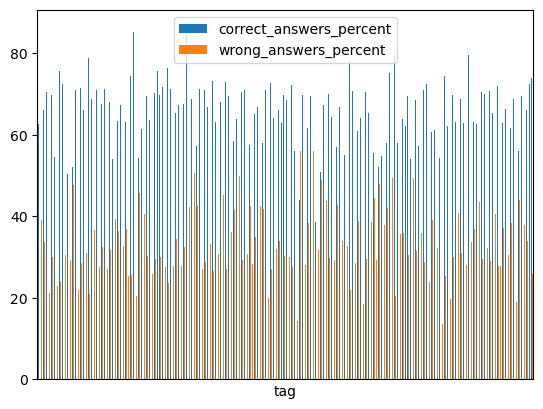

In [ ]:
# выводим статистику правельных и ошибочный ответов по тэгам
qtags_stat_pivoted.plot(
    x="tag", 
    y=["correct_answers_percent", "wrong_answers_percent"], 
    kind="bar",
    xticks=[]
    ) 

In [ ]:
# выводим статистику правельных и ошибочный ответов по тэгам
display(HTML(qtags_stat_pivoted.to_html(classes='scrollable')))

,tag,wrong_answers,correct_answers,total_answers,correct_answers_percent,wrong_answers_percent
0,0,122023.0,204656.0,326679.0,62.647431,37.352569
1,1,943884.0,1465625.0,2409509.0,60.826708,39.173292
2,10,863822.0,1692437.0,2556259.0,66.207571,33.792429
3,100,521028.0,1244951.0,1765979.0,70.496365,29.503635
4,101,77641.0,289828.0,367469.0,78.871415,21.128585
5,102,2708398.0,6283353.0,8991751.0,69.879081,30.120919
6,103,735926.0,888032.0,1623958.0,54.683188,45.316812
7,104,109171.0,369029.0,478200.0,77.170431,22.829569
8,105,125836.0,392740.0,518576.0,75.734319,24.265681
9,106,621809.0,1634902.0,2256711.0,72.446228,27.553772


,part,correct_answers,wrong_answers,total_answers,correct_answers_percent,wrong_answers_percent
0,1,5553896.0,1900674.0,7454570.0,74.503238,25.496762
1,2,13283339.0,5460065.0,18743404.0,70.869406,29.130594
2,3,6060514.0,2579393.0,8639907.0,70.145593,29.854407
3,4,5090684.0,2976992.0,8067676.0,63.099758,36.900242
4,5,24957570.0,15950583.0,40908153.0,61.008792,38.991208
5,6,7029563.0,3471909.0,10501472.0,66.938835,33.061165
6,7,3269061.0,1687057.0,4956118.0,65.960112,34.039888


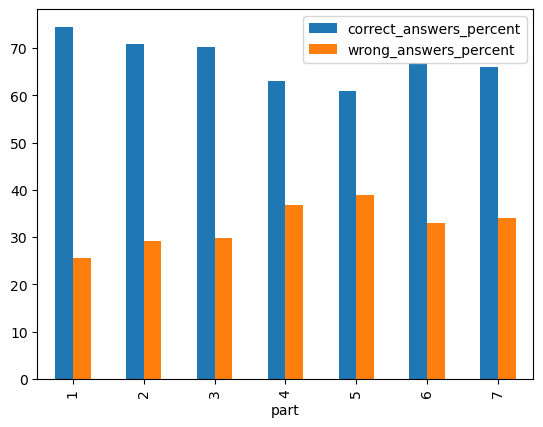

In [ ]:
# выводим статистику правельных и ошибочный ответов по частям
qparts_stat_pivoted.plot(
    x="part", 
    y=["correct_answers_percent", "wrong_answers_percent"], 
    kind="bar"
    ) 

# выводим статистику правельных и ошибочный ответов по частям
qparts_stat_pivoted

,question_id,wrong_answers,correct_answers,total_answers,correct_answers_percent,wrong_answers_percent
0,0,637.0,6266.0,6903.0,90.772128,9.227872
1,1,809.0,6589.0,7398.0,89.064612,10.935388
2,2,20015.0,24890.0,44905.0,55.428126,44.571874
3,3,5067.0,17906.0,22973.0,77.943673,22.056327
4,4,12275.0,19461.0,31736.0,61.321528,38.678472
...,...,...,...,...,...,...
13518,13518,185.0,683.0,868.0,78.686636,21.313364
13519,13519,396.0,528.0,924.0,57.142857,42.857143
13520,13520,282.0,579.0,861.0,67.247387,32.752613
13521,13521,167.0,703.0,870.0,80.804598,19.195402


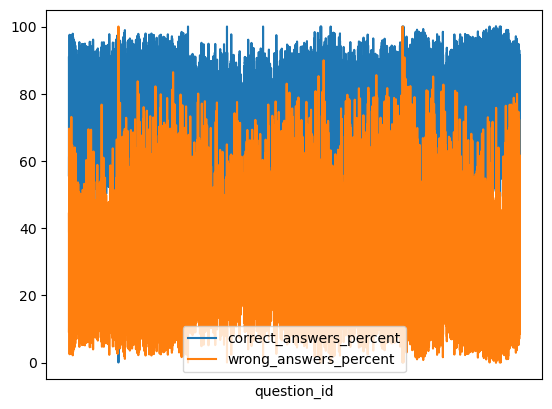

In [ ]:
# выводим статистику правельных и ошибочный ответов по вопросам
questions_stat_pivoted.plot(
    x="question_id", 
    y=["correct_answers_percent", "wrong_answers_percent"], 
    xticks=[]
    ) 

# выводим статистику правельных и ошибочный ответов по вопросам
questions_stat_pivoted


In [ ]:
# сводим статистику для успешных/не успешных в одну строку (количество, среднее время, наличие обьяснений) 
user_info = (
    users_stat_grouped[['user_id','answered_correctly', 'answers_quantity', 'average_time','had_explanation']]
    .pivot_table(
        index=['user_id'], 
        columns=['answered_correctly'],
        values=['answers_quantity', 'average_time','had_explanation'],
        fill_value=0)
    .reset_index()
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
user_info.reset_index(inplace=True)
user_info.columns = [
    'index',
    'user_id', 
    'wrong_answers_quantity', 
    'sccss_answers_quantity', 
    'wrong_average_time', 
    'sccss_average_time',
    'wrong_had_explanation',
    'sccss_had_explanation',
]
# убираем лишние столбцы
user_info = user_info[[
    'user_id', 
    'wrong_answers_quantity', 
    'sccss_answers_quantity', 
    'wrong_average_time', 
    'sccss_average_time',
    'wrong_had_explanation',
    'sccss_had_explanation',
]]
# джойним лекции к пользователю
user_info = pd.merge(user_info, lectures_stat_grouped, how='inner', left_on='user_id', right_on='user_id')
# заменяем пустые значения нулем
user_info.fillna(0, inplace=True)
# рассчитываем процент прослушанных лекций от общего количества
user_info['lectures_percent'] = user_info.lectures_quantity / lectures_count
# рассчитываем среднее время ответов на вопросы
user_info['average_time'] = (
    (user_info.sccss_average_time * user_info.sccss_answers_quantity + user_info.wrong_average_time * user_info.wrong_answers_quantity) / 
    (user_info.sccss_answers_quantity + user_info.wrong_answers_quantity)
)
# рассчитываем общее количество ответов
user_info['answers_quantity'] = user_info.sccss_answers_quantity + user_info.wrong_answers_quantity
# расчитываем процент успешных ответов
user_info['sccss_answers_percent'] = user_info.sccss_answers_quantity * 100 / user_info.answers_quantity
# рассчитываем процент ошибочных ответов
user_info['wrong_answers_percent'] = user_info.wrong_answers_quantity * 100 / user_info.answers_quantity
# рассчитываем процент обьяснений для успешных ответов
user_info['sccss_explanation_percent'] = user_info.sccss_had_explanation * 100 / user_info.answers_quantity
# рассчитываем процент обьяснений для ошибочных ответов
user_info['wrong_explanation_percent'] = user_info.wrong_had_explanation * 100 / user_info.answers_quantity
# рассчитываем процент среднего времени потраченного на успешный ответ относительно максимального времени
user_info['sccss_elapsed_time_percent'] = user_info.sccss_average_time / max_question_elapsed_time
# рассчитываем процент среднего времени потраченного на ошибочный ответ относительно максимального времени
user_info['wrong_elapsed_time_percent'] = user_info.wrong_average_time / max_question_elapsed_time

user_info

C:\Users\Vlad\AppData\Local\Temp\ipykernel_15852\1303664788.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .pivot_table(


,user_id,wrong_answers_quantity,sccss_answers_quantity,wrong_average_time,sccss_average_time,wrong_had_explanation,sccss_had_explanation,lectures_quantity,lectures_percent,average_time,answers_quantity,sccss_answers_percent,wrong_answers_percent,sccss_explanation_percent,wrong_explanation_percent,sccss_elapsed_time_percent,wrong_elapsed_time_percent
0,2746,8.0,11.0,19625.000000,15272.727273,4.0,7.0,1,0.239234,17105.263158,19.0,57.894737,42.105263,36.842105,21.052632,5.090909,6.541667
1,5382,41.0,84.0,40926.829268,33238.095238,35.0,78.0,3,0.717703,35760.000000,125.0,67.200000,32.800000,62.400000,28.000000,11.079365,13.642276
2,8623,39.0,70.0,34276.923077,21182.857143,36.0,60.0,3,0.717703,25867.889908,109.0,64.220183,35.779817,55.045872,33.027523,7.060952,11.425641
3,12741,113.0,152.0,36188.212389,42283.875000,106.0,144.0,6,1.435407,39684.592453,265.0,57.358491,42.641509,54.339623,40.000000,14.094625,12.062737
4,13134,365.0,878.0,23054.041096,21001.268793,359.0,874.0,7,1.674641,21604.053902,1243.0,70.635559,29.364441,70.313757,28.881738,7.000423,7.684680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149601,2147419988,353.0,364.0,39941.847025,36440.989011,346.0,355.0,44,10.526316,38164.563459,717.0,50.767085,49.232915,49.511855,48.256625,12.146996,13.313949
149602,2147469944,73.0,200.0,19424.479452,17969.425000,52.0,189.0,3,0.717703,18358.505495,273.0,73.260073,26.739927,69.230769,19.047619,5.989808,6.474826
149603,2147470770,53.0,173.0,28359.962264,21442.676301,36.0,159.0,2,0.478469,23064.871681,226.0,76.548673,23.451327,70.353982,15.929204,7.147559,9.453321
149604,2147470777,232.0,520.0,20787.780172,19650.655769,216.0,505.0,6,1.435407,20001.470745,752.0,69.148936,30.851064,67.154255,28.723404,6.550219,6.929260


In [ ]:
# сводим статистику для успешных/не успешных оветов для каждого студента на определенной стадии прогресса в одну строку
users_progress_per_users = (
    users_progress
    .pivot_table(
        index=['user_id', 'progress_stage'], 
        columns=['answered_correctly'],
        values='answers_quantity',
        fill_value=0)
    .add_suffix('_answers')
    .reset_index()
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
users_progress_per_users.reset_index(inplace=True)
users_progress_per_users.columns = ['', 'user_id', 'time progress %', 'wrong answers', 'correct answers']
users_progress_per_users = users_progress_per_users[['user_id', 'time progress %', 'wrong answers', 'correct answers']]
# получаем общее количество успешных и ошибочных ответов
total_answers = users_progress_per_users.agg({
                'correct answers':['sum'],
                'wrong answers':['sum']
                })
total_answers.columns = ['correct answers', 'wrong answers']
correct_answers = total_answers['correct answers'].loc[total_answers.index[0]]
wrong_answers = total_answers['wrong answers'].loc[total_answers.index[0]]
# вычисляем средний процент верных ответов
correct_answers_perc = correct_answers * 100 / (correct_answers + wrong_answers)

# агрегируем по стадиям прогресса (количество пользователей, сумма корректных и ошибочных ответов)
progress_statistics = (
    users_progress_per_users
    .groupby(by=['time progress %']).agg({
                'user_id':['count'],
                'correct answers':['sum'],
                'wrong answers':['sum']
                })                
)
# сбрасываем идекс и устанавливаем более удобные названия столбцов для дальнейшей работы с ними
progress_statistics.reset_index(inplace=True)
progress_statistics.columns = ['time progress %', 'users quantyty', 'correct answers', 'wrong answers']
# расчитываем среднее количество правельных ответов на одного пользователя
progress_statistics['correct answers per user'] = progress_statistics['correct answers'] / progress_statistics['users quantyty'] 
# расчитываем среднее количество ошибочных ответов на одного пользователя
progress_statistics['wrong answers per user'] = progress_statistics['wrong answers'] / progress_statistics['users quantyty'] 
# расчитываем всредний процент корректных ответов относительно общего количества для одного пользователя
progress_statistics['correct answers %'] = progress_statistics['correct answers per user'] * 100 / (
    progress_statistics['correct answers per user'] + progress_statistics['wrong answers per user']
)

In [ ]:
# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['sccss_answers_percent','sccss_elapsed_time_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
succ_ans_to_time_corr = corr_matrix.loc[0,'sccss_elapsed_time_percent']

# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['wrong_answers_percent','wrong_elapsed_time_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
wrong_ans_to_time_corr = corr_matrix.loc[0,'wrong_elapsed_time_percent']



# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['sccss_answers_percent','sccss_explanation_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
sccss_ans_to_explanation_corr = corr_matrix.loc[0,'sccss_explanation_percent']

# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['wrong_answers_percent','wrong_explanation_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
wrong_ans_to_explanation_corr = corr_matrix.loc[0,'wrong_explanation_percent']



# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['sccss_answers_percent','lectures_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
sccss_ans_to_lectures_corr = corr_matrix.loc[0,'lectures_percent']

# вычисляем коэффициент корреляции между наборами данных
corr_matrix = user_info[['wrong_answers_percent','lectures_percent']].corr()
# сбрасываем идекс для удобства дальнейшей работы с датафреймом
corr_matrix.reset_index(inplace=True)
# получаем значение коэффициента корреляции
wrong_ans_to_lectures_corr = corr_matrix.loc[0,'lectures_percent']


# выводим расчитанные значения
print(f'''
Коэффициент корреляции между количеством ответов студентов и средним временем ответа на вопрос студентами: 
Корреляция по ошибочным ответам: {round(wrong_ans_to_time_corr,3)}
Корреляция по верным ответам:    {round(succ_ans_to_time_corr, 3)}

Коэффициент корреляции между количеством ответов студентов и количеством ответов имевших обьяснение: 
Корреляция по ошибочным ответам: {round(wrong_ans_to_explanation_corr, 3)}
Корреляция по верным ответам:    {round(sccss_ans_to_explanation_corr, 3)}

Коэффициент корреляции между количеством ответов студентов и количеством посещаемых лекций:
Корреляция по ошибочным ответам: {round(wrong_ans_to_lectures_corr, 3)}
Корреляция по верным ответам:    {round(sccss_ans_to_lectures_corr, 3)}

''')



Коэффициент корреляции между количеством ответов студентов и средним временем ответа на вопрос студентами: 
Корреляция по ошибочным ответам: -0.03
Корреляция по верным ответам:    -0.044

Коэффициент корреляции между количеством ответов студентов и количеством ответов имевших обьяснение: 
Корреляция по ошибочным ответам: 0.693
Корреляция по верным ответам:    0.888

Коэффициент корреляции между количеством ответов студентов и количеством посещаемых лекций:
Корреляция по ошибочным ответам: -0.167
Корреляция по верным ответам:    0.167




Временная динамика удельного балланса верных и ошибочных ответов по всем студентам приведенная к процентной шкале


<Axes: xlabel='time progress %'>

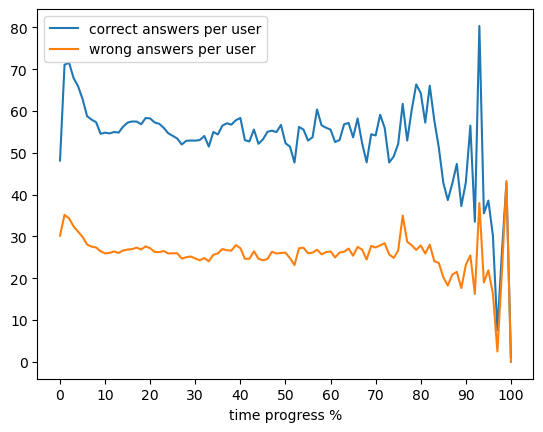

In [ ]:
print('Временная динамика удельного балланса верных и ошибочных ответов по всем студентам приведенная к процентной шкале')
# отображаем данные в виде графика
progress_statistics.plot(
    x="time progress %", 
    y=["correct answers per user", "wrong answers per user"], 
#    kind="bar", 
    xticks=range(0,100+1,10)) 


Средний процент правельных ответов: 65.72 %



Временная динамика процента верных ответов по всем студентам приведенная к процентной шкале


<Axes: xlabel='time progress %'>

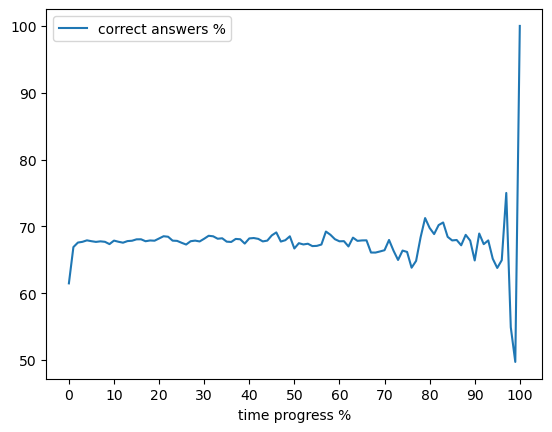

In [ ]:
print(f'Средний процент правельных ответов: {round(correct_answers_perc, 2)} %\n\n\n')
print('Временная динамика процента верных ответов по всем студентам приведенная к процентной шкале')
# отображаем данные в виде графика
progress_statistics.plot(
    x="time progress %", 
    y=["correct answers %"], 
    xticks=range(0,100+1,10)) 

Временная динамика количества студентов учавствующий в ответах приведенная к процентной шкале


<Axes: xlabel='time progress %'>

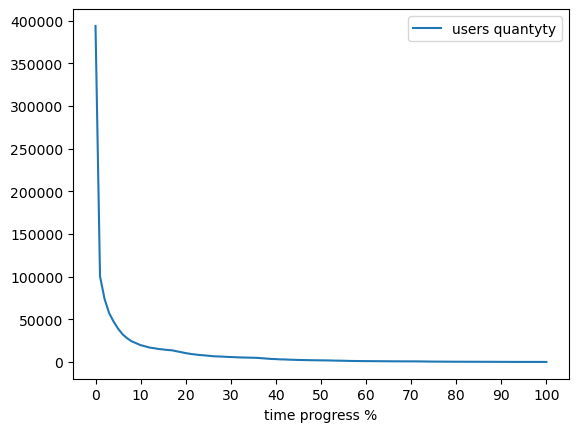

In [ ]:

print('Временная динамика количества студентов учавствующий в ответах приведенная к процентной шкале')
# отображаем данные в виде графика
progress_statistics.plot(
    x="time progress %", 
    y=["users quantyty"], 
    xticks=range(0,100+1,10)) 